※ Global variables

In [40]:
import torch

gnDataset = 3
gBase_path = 'CAS771/Task1_data'
gnClasses = 5
gSaveModelAll = True

gDropout_rate = [0.9, 0.9, 0.9]
gBatch_momentum = [0.1, 0.1, 0.1]
gLearning_rate = [0.00001, 0.00001, 0.00001]
gWeight_decay = [1e-3, 1e-3, 1e-3]
gOpt_Momentum = [0.9, 0.9, 0.9]

gData_batch_size = 32
gEarly_stop_patience = 150
gnEpochs = 300
gbData_augmentation = True

gModel_names = ["cnn2", "cnn2", "cnn2"] # "resnet", "cnn"
gOptimizer_names = ["Adam", "Adam", "Adam"] # "Adam", "SGD"
gCriterion_names = ["CrossEntropyLoss", "CrossEntropyLoss", "CrossEntropyLoss"]


import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

※ Widget functions

In [22]:
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle

class CAS771Dataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        if self.transform and not isinstance(img, torch.Tensor):
            img = self.transform(img)
        return img, label

def _load_data(train_data_path):
    raw_data = torch.load(train_data_path)
    data = raw_data['data']
    labels = raw_data['labels']
    return data, labels

def remap_labels(labels, class_mapping):
    return [class_mapping[label] for label in labels]

def load_class_names(filepath):
    with open(filepath, 'r') as file:
        classes = [line.strip() for line in file]
    return classes

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def count_layers(model):
    layer_count = 0
    for module in model.children():
        if not isinstance(module, nn.Dropout):  # deduct Dropout
            layer_count += 1
    return layer_count


class CAS771Plot():
    def __init__(self, model, criterion, device, train_dataloader, test_dataloader, model_num):
        self.model = model
        self.criterion = criterion 
        self.device = device
        self.train_losses = []
        self.validation_losses = []
        self.validation_accuracies = []
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.running_loss = 0.0
        self.model_num = model_num + 1
    
    def init_running_loss(self):
        self.running_loss = 0.0

    def add_loss(self, loss):
        self.running_loss += loss

    def append(self, epoch):
        train_loss = self.running_loss / len(self.train_dataloader)
        validation_loss, validation_accuracy = self._validate()
        self.train_losses.append(train_loss)
        self.validation_losses.append(validation_loss)
        self.validation_accuracies.append(validation_accuracy)
        self._print(epoch, train_loss, validation_loss, validation_accuracy)
        return validation_loss

    def plot(self):
        self._plot_metrics(self.train_losses, self.validation_losses, self.validation_accuracies, self.model_num)
    
    def _print(self, epoch, train_loss, validation_loss, validation_accuracy):
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

    def _validate(self):
        self.model.eval()  # evaluation mode
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        
        with torch.no_grad():  # disable gradient calculations
            for inputs, labels in self.test_dataloader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_samples += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()
        
        validation_loss = running_loss / len(self.test_dataloader)
        validation_accuracy = correct_predictions / total_samples
        return validation_loss, validation_accuracy

    def _plot_metrics(self, train_losses, validation_losses, validation_accuracies, model_num):
        epochs = range(1, len(train_losses) + 1)

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_losses, label='Train Loss', marker='o')
        plt.plot(epochs, validation_losses, label='Validation Loss', marker='o')
        plt.title(f'Model {model_num} Learning per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(epochs, validation_accuracies, label='Validation Accuracy', marker='o', color='green')
        plt.title(f'Model {model_num} Accuracy per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()    


class CAS771EarlyStopping():
    def __init__(self):
        self.best_val_loss = float('inf')
        self.patience_counter = 0

    def isStop(self, validation_loss):
        if validation_loss < self.best_val_loss: # 검증 손실이 감소하면 best_val_loss 업데이트
            self.best_val_loss = validation_loss
            self.patience_counter = 0
        else:
            self.patience_counter += 1
        
        if self.patience_counter >= gEarly_stop_patience: # 검증 손실이 감소하지 않으면 학습 종료
            print("Early stopping")
            return True
        else:
            return False

def get_data_augmentation(mode):
    if gbData_augmentation == False:
        return None
    
    if mode == "train":
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(), # inverse left-right
            transforms.RandomRotation(degrees=15), # random rotate
            transforms.RandomResizedCrop(32, scale=(0.8, 1.0)), # random crop
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # normalization
        ])
    else:
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

def load_data(train_data_path, test_data_path, m=0, save_class_mapping=True):
    train_data, train_labels = _load_data(train_data_path)
    unique_labels = sorted(set(train_labels))
    class_mapping = {label: i for i, label in enumerate(unique_labels)}
    print(f"Class mapping: {class_mapping}")
    
    if train_data_path == None:
        train_dataloader = None
    else:
        train_remapped_labels = remap_labels(train_labels, class_mapping)
        transform = get_data_augmentation("train")
        train_dataset = CAS771Dataset(train_data, train_remapped_labels, transform=transform)
        train_dataloader = DataLoader(train_dataset, batch_size=gData_batch_size, shuffle=True, drop_last=False)

        if save_class_mapping:
            # Save the mapping to a file
            class_mapping_path = f'{gBase_path}/Model{m+1}/class_mapping_model_{m+1}.pkl'
            with open(class_mapping_path, "wb") as f:
                pickle.dump(class_mapping, f)

    if test_data_path == None:
        test_dataloader = None
    else:
        test_data, test_labels = _load_data(test_data_path)
        remapped_test_labels = remap_labels(test_labels, class_mapping)
        transform = get_data_augmentation("test")
        test_dataset = CAS771Dataset(test_data, remapped_test_labels, transform=transform)
        test_dataloader = DataLoader(test_dataset, batch_size=gData_batch_size, shuffle=False, drop_last=False)

    return train_dataloader, test_dataloader

※ Datasets

In [4]:
train_data_paths = [f'{gBase_path}/Model{i}/model{i}_train.pth' for i in range(1, gnDataset+1)]
test_data_paths = [f'{gBase_path}/Model{i}/model{i}_test.pth' for i in range(1, gnDataset+1)]
print(train_data_paths)
print(test_data_paths)

classes_path = gBase_path + '/cifar100_classes.txt'
classes = load_class_names(classes_path)
print(classes)

['CAS771/Task1_data/Model1/model1_train.pth', 'CAS771/Task1_data/Model2/model2_train.pth', 'CAS771/Task1_data/Model3/model3_train.pth']
['CAS771/Task1_data/Model1/model1_test.pth', 'CAS771/Task1_data/Model2/model2_test.pth', 'CAS771/Task1_data/Model3/model3_test.pth']
['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea'

※ Models

1. ResNet18

In [5]:
# Define Basic Block (Residual Block)
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout_rate=0.0, batch_momentum=0.1):
        super(BasicBlock, self).__init__()
        # 1st Convolution Layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels, momentum=batch_momentum)
        
        # 2nd Convolution Layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels, momentum=batch_momentum)
        
        # Skip connection (identity)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels, momentum=batch_momentum)
            )

        # Dropout Layer (After Batch Normalization)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # Residual connection + ReLU activation
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  # skip connection
        out = F.relu(out)
        return out
    
# Define Modified ResNet-18
class ResNet18(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5, batch_momentum=0.1):
        super(ResNet18, self).__init__()
        self.in_channels = 32  
        # 1st Layer (Conv + Maxpool)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=3, bias=False) 
        self.bn1 = nn.BatchNorm2d(32, momentum=batch_momentum)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # Residual Blocks (each block is BasicBlock)
        #self.layer0 = self._make_layer(64, 2, stride=1, dropout_rate=dropout_rate/2)   
        self.layer1 = self._make_layer(64, 2, 
                                       stride=1, dropout_rate=dropout_rate/2,
                                       batch_momentum=batch_momentum)   
        self.layer2 = self._make_layer(128, 2, stride=2, 
                                       dropout_rate=dropout_rate/2,
                                       batch_momentum=batch_momentum) 
        self.layer3 = self._make_layer(256, 2, stride=2, dropout_rate=dropout_rate/2,
                                       batch_momentum=batch_momentum) 
        self.layer4 = self._make_layer(256, 2, stride=2, dropout_rate=dropout_rate/2,
                                       batch_momentum=batch_momentum) 
        # Fully Connected Layer
        self.fc = nn.Linear(256, num_classes) 
        # Dropout
        self.dropout = nn.Dropout(dropout_rate)

    def _make_layer(self, out_channels, num_blocks, stride, dropout_rate, batch_momentum):
        layers = []
        layers.append(BasicBlock(self.in_channels, 
                                 out_channels, 
                                 stride, 
                                 dropout_rate=dropout_rate,
                                 batch_momentum=batch_momentum))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(self.in_channels, out_channels, dropout_rate=dropout_rate))
        return nn.Sequential(*layers)

    def forward(self, x):
        # 1st Convolution + Maxpool
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        # Residual Blocks
        #x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # Fully Connected
        x = torch.flatten(x, 1)  # Flatten the tensor
        x = self.dropout(x)      # Apply Dropout
        x = self.fc(x)
        
        return x

2. CNN

In [8]:
'''
gnGPU = "0"
gnDataset = 3
gBase_path = 'CAS771/Task1_data'
gnClasses = 5
gDropout_rate = 0.9
gBatch_momentum = 0.1
gLearning_rate = 0.00001
gWeight_decay = 1e-3
gOpt_Momentum = 0.9
gData_batch_size = 32
gEarly_stop_patience = 15
gnEpochs = 200
gbData_augmentation = False

'''
class CNN(nn.Module):
    def __init__(self, num_classes, dropout_rate=gDropout_rate):
        super(CNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        
        # Pooling layers
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)
        
        # Calculate the flattened size by passing dummy input
        dummy_input = torch.randn(1, 3, 32, 32)
        dummy_output = self.pool2(F.relu(self.bn3(self.conv3(self.pool1(F.relu(self.bn2(self.conv2(F.relu(self.bn1(self.conv1(dummy_input)))))))))))
        flattened_size = dummy_output.view(1, -1).size(1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(flattened_size, 64)
        self.fc2 = nn.Linear(64, num_classes)
        
        # Dropout
        self.dropout = nn.Dropout(dropout_rate)
       
    def forward(self, x, return_embedding=False):
        '''
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.pool1(x)
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.pool2(x)
        '''

        # Convolutional layer + ReLU + Batch Normalization
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x) # first pooling
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool2(x) # second pooling

        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers + Dropout
        embedding = self.dropout(F.relu(self.fc1(x)))

        if return_embedding:
            return embedding  # Feature vector 반환
        
        x = self.fc2(embedding)
        return x

In [33]:
class CNN4(nn.Module):
    def __init__(self, num_classes):
        super(CNN4, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        # Pooling layers
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(32*8*8, 512)
        self.fc2 = nn.Linear(512, num_classes)
       
    def forward(self, x, return_embedding=False):

        # Convolutional layer + ReLU + Batch Normalization
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        batch_size = x.size(0)  # 현재 batch size를 가져옴
        x = x.view(batch_size, -1)  # 텐서를 2차원으로 펼침 (Batch Size, Flattened Feature Vector)

        x = F.relu(self.fc1(x))
        x = self.fc2(x) 

        return x

3. CNN2

In [10]:
'''
gnGPU = "0"
gnDataset = 3
gBase_path = 'CAS771/Task1_data'
gnClasses = 5
gDropout_rate = 0.9
gBatch_momentum = 0.1
gLearning_rate = 0.00001
gWeight_decay = 1e-3
gOpt_Momentum = 0.9
gData_batch_size = 32
gEarly_stop_patience = 15
gnEpochs = 200
gbData_augmentation = False

'''
class CNN2(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(CNN2, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        
        # Pooling layers
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)
        
        # Calculate the flattened size by passing dummy input
        dummy_input = torch.randn(1, 3, 32, 32)
        dummy_output = self.pool2(F.relu(self.bn3(self.conv3(self.pool1(F.relu(self.bn2(self.conv2(F.relu(self.bn1(self.conv1(dummy_input)))))))))))
        flattened_size = dummy_output.view(1, -1).size(1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(flattened_size, 465)
        self.fc2 = nn.Linear(465, num_classes)
        
        # Dropout
        self.dropout = nn.Dropout(dropout_rate)
       
    def forward(self, x, return_embedding=False):
        # Convolutional layer + ReLU + Batch Normalization
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x) # first pooling
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool2(x) # second pooling
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers + Dropout
        x = self.dropout(F.relu(self.fc1(x)))

        if return_embedding:
            return x  # Feature vector 반환

        x = self.fc2(x)
        return x

※ Model Functions

In [11]:
def _get_model(model_name, dropout_rate, batch_momentum, m = 0):
    if model_name == "resnet":
        model = ResNet18(num_classes=gnClasses, 
                        dropout_rate=dropout_rate, 
                        batch_momentum=batch_momentum).to(device)
    elif model_name == "cnn":
        model = CNN(num_classes=gnClasses,
                     dropout_rate=dropout_rate).to(device)
    elif model_name == "cnn2":
        model = CNN2(num_classes=gnClasses,
                     dropout_rate=dropout_rate).to(device)
    elif model_name == "cnn4":
        model = CNN4(num_classes=gnClasses).to(device)


    print(f"Model{m+1} parameters: {count_parameters(model)}")
    print(f"Model{m+1} Total layers: {count_layers(model)}")
    return model

def _get_optimizer(opname, model, learning_rate, weight_decay, opt_momentum):
    if opname == "Adam":
        return optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif opname == "SGD":
        return optim.SGD(model.parameters(), lr=learning_rate, momentum = opt_momentum, weight_decay=weight_decay)

def _get_criterion(criterion_name):
    if criterion_name == "CrossEntropyLoss":
        return nn.CrossEntropyLoss()
    return nn.CrossEntropyLoss()

def get_models(model_names, optimizer_names, criterion_names):
    models = []
    optimizers = []
    criterions = []
    for m in range(gnDataset):
        models.append(_get_model(model_names[m], gDropout_rate[m], gBatch_momentum[m], m))
        optimizers.append(_get_optimizer(optimizer_names[m], models[m], gLearning_rate[m], gWeight_decay[m], gOpt_Momentum[m]))
        criterions.append(_get_criterion(criterion_names[m]))
    
    return models, optimizers, criterions

    
def save_model(model, m=0, all=False):
    if all == True:
        model_saved_path = f"{gBase_path}/Model{m+1}/model{m+1}_all.pth"
        torch.save(model, model_saved_path)
    else:
        model_saved_path = f"{gBase_path}/Model{m+1}/model{m+1}_weights.pth"
        torch.save(model.state_dict(), model_saved_path)

    print(f"Model{m+1} is saved to: {model_saved_path}")

def load_model(model, m=0, all=False):
    if all == True:
        model_saved_path = f"{gBase_path}/Model{m+1}/model{m+1}_all.pth"
        model.load(model_saved_path)
    else:
        model_saved_path = f"{gBase_path}/Model{m+1}/model{m+1}_weights.pth"
        model.load_state_dict(torch.load(model_saved_path))

    print(f"Model{m+1} is loaded from: {model_saved_path}")


※ Training / Validating for each model

Model1 parameters: 7993067
Model1 Total layers: 10
Model2 parameters: 7993067
Model2 Total layers: 10
Model3 parameters: 7993067
Model3 Total layers: 10
Class mapping: {0: 0, 10: 1, 20: 2, 30: 3, 40: 4}
Epoch 1, Train Loss: 1.4561, Validation Loss: 1.0838, Validation Accuracy: 0.6400
Epoch 2, Train Loss: 1.1943, Validation Loss: 0.9561, Validation Accuracy: 0.6580
Epoch 3, Train Loss: 1.1230, Validation Loss: 0.9015, Validation Accuracy: 0.6800
Epoch 4, Train Loss: 1.0496, Validation Loss: 0.8649, Validation Accuracy: 0.7000
Epoch 5, Train Loss: 1.0265, Validation Loss: 0.8259, Validation Accuracy: 0.7120
Epoch 6, Train Loss: 0.9743, Validation Loss: 0.7976, Validation Accuracy: 0.7220
Epoch 7, Train Loss: 0.9310, Validation Loss: 0.7653, Validation Accuracy: 0.7240
Epoch 8, Train Loss: 0.9239, Validation Loss: 0.7480, Validation Accuracy: 0.7160
Epoch 9, Train Loss: 0.8681, Validation Loss: 0.7289, Validation Accuracy: 0.7300
Epoch 10, Train Loss: 0.8261, Validation Loss: 0.7101, Vali

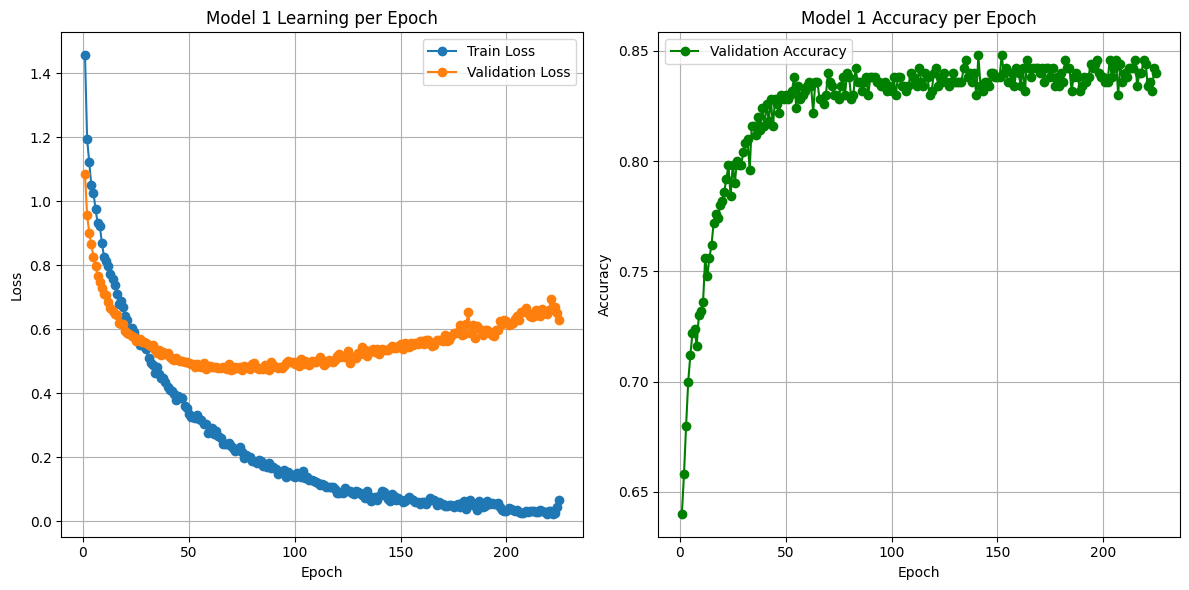

Model1 is saved to: CAS771/Task1_data/Model1/model1_all.pth
Class mapping: {1: 0, 11: 1, 21: 2, 31: 3, 41: 4}
Epoch 1, Train Loss: 1.5312, Validation Loss: 1.2658, Validation Accuracy: 0.5920
Epoch 2, Train Loss: 1.3180, Validation Loss: 1.1271, Validation Accuracy: 0.6260
Epoch 3, Train Loss: 1.2020, Validation Loss: 1.0098, Validation Accuracy: 0.6620
Epoch 4, Train Loss: 1.1169, Validation Loss: 0.9457, Validation Accuracy: 0.6800
Epoch 5, Train Loss: 1.0829, Validation Loss: 0.9035, Validation Accuracy: 0.6800
Epoch 6, Train Loss: 1.0334, Validation Loss: 0.8472, Validation Accuracy: 0.6920
Epoch 7, Train Loss: 0.9771, Validation Loss: 0.8162, Validation Accuracy: 0.7160
Epoch 8, Train Loss: 0.9532, Validation Loss: 0.8027, Validation Accuracy: 0.7140
Epoch 9, Train Loss: 0.9307, Validation Loss: 0.7492, Validation Accuracy: 0.7420
Epoch 10, Train Loss: 0.8817, Validation Loss: 0.7218, Validation Accuracy: 0.7360
Epoch 11, Train Loss: 0.8513, Validation Loss: 0.7059, Validation Acc

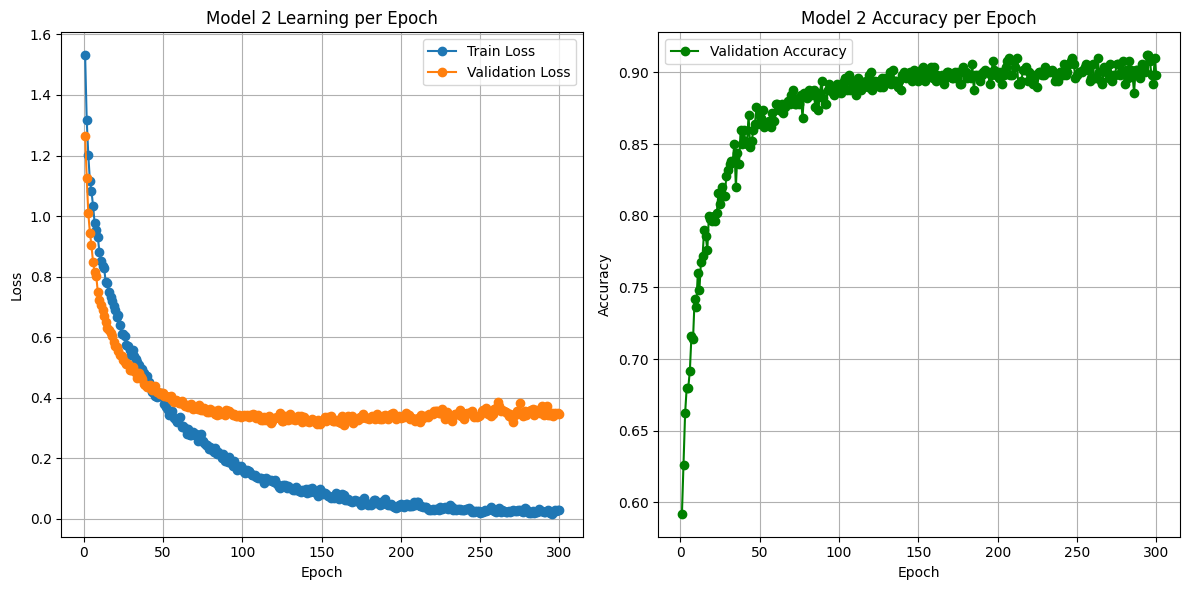

Model2 is saved to: CAS771/Task1_data/Model2/model2_all.pth
Class mapping: {2: 0, 12: 1, 22: 2, 32: 3, 42: 4}
Epoch 1, Train Loss: 1.6312, Validation Loss: 1.3875, Validation Accuracy: 0.5560
Epoch 2, Train Loss: 1.4491, Validation Loss: 1.2798, Validation Accuracy: 0.6100
Epoch 3, Train Loss: 1.3651, Validation Loss: 1.1761, Validation Accuracy: 0.6080
Epoch 4, Train Loss: 1.3073, Validation Loss: 1.1356, Validation Accuracy: 0.6200
Epoch 5, Train Loss: 1.2512, Validation Loss: 1.0962, Validation Accuracy: 0.6280
Epoch 6, Train Loss: 1.2335, Validation Loss: 1.0516, Validation Accuracy: 0.6180
Epoch 7, Train Loss: 1.1915, Validation Loss: 1.0187, Validation Accuracy: 0.6360
Epoch 8, Train Loss: 1.1532, Validation Loss: 0.9927, Validation Accuracy: 0.6400
Epoch 9, Train Loss: 1.1185, Validation Loss: 0.9497, Validation Accuracy: 0.6560
Epoch 10, Train Loss: 1.1119, Validation Loss: 0.9415, Validation Accuracy: 0.6700
Epoch 11, Train Loss: 1.0782, Validation Loss: 0.9075, Validation Acc

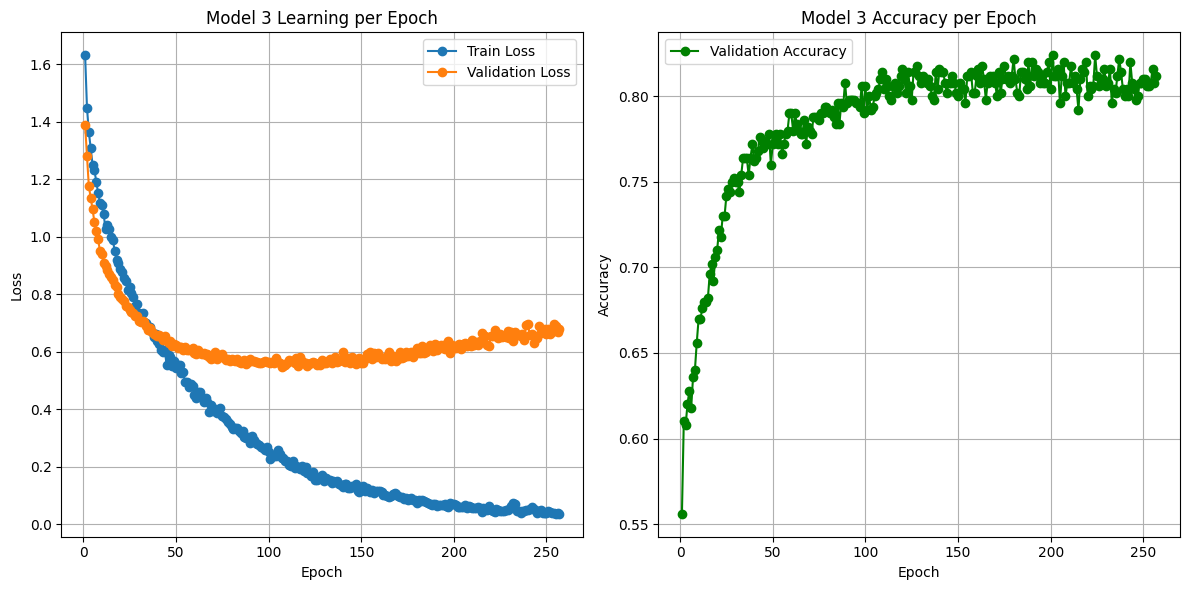

Model3 is saved to: CAS771/Task1_data/Model3/model3_all.pth


In [41]:
models, optimizers, criterions = get_models(gModel_names, gOptimizer_names, gCriterion_names)

for m in range(gnDataset):
    model = models[m]
    optimizer = optimizers[m]
    criterion = criterions[m]
    train_dataloader, test_dataloader = load_data(train_data_paths[m], test_data_paths[m], m)

    progress = CAS771Plot(model, criterion, device, train_dataloader, test_dataloader, m)
    es = CAS771EarlyStopping()

    for epoch in range(gnEpochs):
        model.train()
        progress.init_running_loss()

        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device) # move data to GPU/CPU
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            progress.add_loss(loss.item())
        
        if es.isStop(progress.append(epoch)):
            break
    progress.plot()
    save_model(model, m, gSaveModelAll)

    del model
torch.cuda.empty_cache()

